In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from collections import Counter

### Estimate the proportion of ones in the population based in a data sample

In [143]:
data = '101110101'
ones = np.sum([1 for s in data if s=='1'])
zeros = np.sum([1 for s in data if s=='0'])
print(f'Data: {data}\n')
print(f'{len(data)} bit observations:')
print(f'  {ones} ones')
print(f'  {zeros} zeros')

Data: 101110101

9 bit observations:
  6 ones
  3 zeros


### Grid Approximation

In [329]:
sample_size = 10000

estimated_posterior = []
defined_grid = []
for grid_size in [5,20]:
    # Determine grid
    p_grid = np.linspace(0, 1, grid_size)
    # Estimate likelihood
    likelihood = []
    for p in p_grid:
        trial = np.random.binomial(n=9, p=p, size=sample_size)
        q = np.sum(np.where(trial==6,1,0))/sample_size
        likelihood.append(q)
    # Define prior
    prior = np.ones(grid_size)/grid_size
    # Compute posterior
    posterior = likelihood * prior
    # Stadarize posterior
    posterior = posterior / np.sum(posterior)
    defined_grid.append(p_grid)
    estimated_posterior.append(posterior)
    

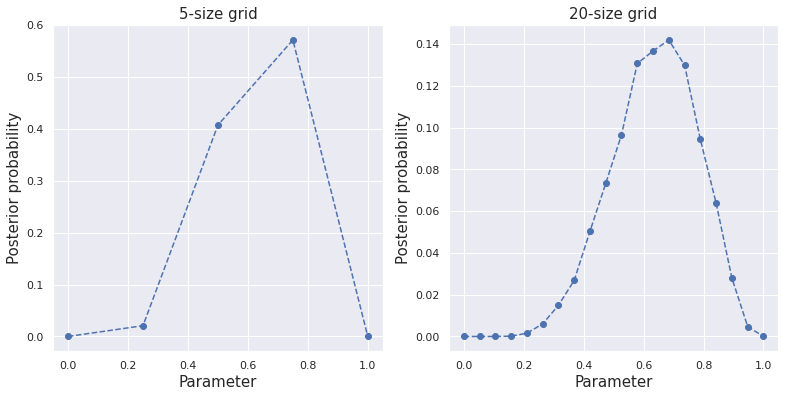

In [330]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

ax=ax1
ax.set_title(f'{len(defined_grid[0])}-size grid', fontsize=15)
ax.plot(defined_grid[0], estimated_posterior[0], marker='o', linestyle='--')
ax.set_xlabel('Parameter', fontsize=15)
ax.set_ylabel('Posterior probability', fontsize=15)

ax=ax2
ax.set_title(f'{len(defined_grid[1])}-size grid', fontsize=15)
ax.plot(defined_grid[1], estimated_posterior[1], marker='o', linestyle='--')
ax.set_xlabel('Parameter', fontsize=15)
ax.set_ylabel('Posterior probability', fontsize=15)


plt.show()

### MCMC

In [180]:
n_ones = 6
n_zeros = 3
p = [0.5]
for i in np.arange(1, 1000):
    p_new = np.random.normal(p[i-1], 0.1, size=1) # Centered on previos value
    if p_new < 0:
        p_new = np.abs(p_new)
    elif p_new > 1:
        p_new = 2-p_new
    
    p_new = p_new.item()
    
    trial = np.random.binomial(n=9, p=p[i-1], size=sample_size) # Likelihood given last estimation
    q0 = np.sum(np.where(trial==6,1,0))/sample_size

    trial = np.random.binomial(n=9, p=p_new, size=sample_size) # Likelihood given new estimation
    q1 = np.sum(np.where(trial==6,1,0))/sample_size
    
    r = np.random.uniform()
    if r < (q1/q0): # Com
        p.append(p_new)
    else:
        p.append(p[i-1])
            

In [325]:
def bin_means(x, bins=10):
    buckets = pd.cut(pd.Series(x), bins=bins, labels=False)
    s_min, s_max = pd.Series(x).min(), pd.Series(x).max()
    values = np.linspace(s_min, s_max, bins+1)
    means = np.convolve(values, np.ones(2), 'valid') / 2
    
    df = pd.DataFrame.from_dict(Counter(pd.cut(pd.Series(p), bins=bins, labels=False)), orient='index').reset_index()
    df.columns = ['bin','count']
    df['freq'] = df['count']/df['count'].sum()
    df.sort_values('bin', inplace=True)
    df['center'] = np.round(means,2)
    
    return df

In [326]:
df = bin_means(p, bins=15)
df.head(1)

,bin,count,freq,center
8,0,7,0.007,0.28


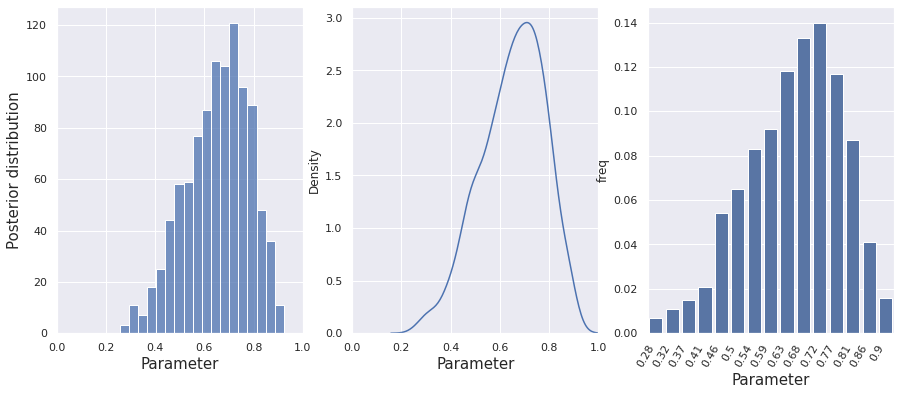

In [328]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax=ax1
sns.histplot(p, ax=ax)
ax.set_xlim(0,1)
ax.set_xlabel('Parameter', fontsize=15)
ax.set_ylabel('Posterior distribution', fontsize=15)

ax=ax2
sns.kdeplot(p, ax=ax)
ax.set_xlim(0,1)
ax.set_xlabel('Parameter', fontsize=15)

ax=ax3
sns.barplot(x=df.center, y=df.freq, color='b', ax=ax)
ax.set_xticklabels(df.center, rotation = 60, ha="right")
ax.set_xlabel('Parameter', fontsize=15)
#ax=ax1
#ax.set_title(f'{len(defined_grid[0])}-size grid', fontsize=15)
#ax.set_xlabel('Parameter', fontsize=15)
#ax.set_ylabel('Posterior probability', fontsize=15)

plt.show()

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 5 to 9
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bin     10 non-null     int64  
 1   count   10 non-null     int64  
 2   freq    10 non-null     float64
 3   center  10 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 400.0 bytes


In [245]:
pd.cut(pd.Series(p), bins=10, labels=False).sort_values()

913    0
962    0
961    0
446    0
29     0
      ..
757    9
971    9
972    9
825    9
107    9
Length: 1000, dtype: int64

In [235]:
pd.cut(pd.Series(p), bins=10).sort_values()

913    (0.255, 0.322]
962    (0.255, 0.322]
961    (0.255, 0.322]
446    (0.255, 0.322]
29     (0.255, 0.322]
            ...      
757    (0.856, 0.923]
971    (0.856, 0.923]
972    (0.856, 0.923]
825    (0.856, 0.923]
107    (0.856, 0.923]
Length: 1000, dtype: category
Categories (10, interval[float64, right]): [(0.255, 0.322] < (0.322, 0.389] < (0.389, 0.456] < (0.456, 0.523] ... (0.656, 0.723] < (0.723, 0.79] < (0.79, 0.856] < (0.856, 0.923]]

In [232]:
pd.Series(p).min(), pd.Series(p).max()

(0.25558738882128984, 0.9230192174534917)

In [234]:
np.linspace(pd.Series(p).min(), pd.Series(p).max(), 11)

array([0.25558739, 0.32233057, 0.38907375, 0.45581694, 0.52256012,
       0.5893033 , 0.65604649, 0.72278967, 0.78953285, 0.85627603,
       0.92301922])

In [236]:
np.convolve(np.linspace(pd.Series(p).min(), pd.Series(p).max(), 11), np.ones(2), 'valid') / 2

array([0.28895898, 0.35570216, 0.42244535, 0.48918853, 0.55593171,
       0.62267489, 0.68941808, 0.75616126, 0.82290444, 0.88964763])

In [207]:
Counter(pd.cut(pd.Series(p), bins=10, labels=False)).values()

dict_values([95, 129, 22, 164, 45, 11, 197, 193, 100, 44])

In [299]:
def bin_means(x, bins=10):
    buckets = pd.cut(pd.Series(x), bins=bins, labels=False)
    s_min, s_max = pd.Series(x).min(), pd.Series(x).max()
    values = np.linspace(s_min, s_max, bins+1)
    means = np.convolve(values, np.ones(2), 'valid') / 2
    
    df = pd.DataFrame.from_dict(Counter(pd.cut(pd.Series(p), bins=bins, labels=False)), orient='index').reset_index()
    df.columns = ['bin','count']
    df['freq'] = df['count']/df['count'].sum()
    df.sort_values('bin', inplace=True)
    df['center'] = np.round(means,2)
    
    return df

In [278]:
bin_means(p)

,bin,count,freq,center
5,0,11,0.011,0.29
2,1,22,0.022,0.36
4,2,45,0.045,0.42
0,3,95,0.095,0.49
1,4,129,0.129,0.56
3,5,164,0.164,0.62
6,6,197,0.197,0.69
7,7,193,0.193,0.76
8,8,100,0.100,0.82
9,9,44,0.044,0.89


In [267]:
Counter(pd.cut(pd.Series(p), bins=10, labels=False)).keys()

dict_keys([3, 4, 1, 5, 2, 0, 6, 7, 8, 9])

In [268]:
df = pd.DataFrame.from_dict(Counter(pd.cut(pd.Series(p), bins=10, labels=False)), orient='index').reset_index()
df.columns = ['bin','count']
df
df['freq'] = df['count']/df['count'].sum()
df.sort_values('bin', inplace=True)
df['val'] = bin_means(p)
df

,bin,count,freq,val
5,0,11,0.011,0.29
2,1,22,0.022,0.36
4,2,45,0.045,0.42
0,3,95,0.095,0.49
1,4,129,0.129,0.56
3,5,164,0.164,0.62
6,6,197,0.197,0.69
7,7,193,0.193,0.76
8,8,100,0.100,0.82
9,9,44,0.044,0.89


In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 5 to 9
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bin     10 non-null     int64  
 1   count   10 non-null     int64  
 2   freq    10 non-null     float64
 3   val     10 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 400.0 bytes


<BarContainer object of 10 artists>

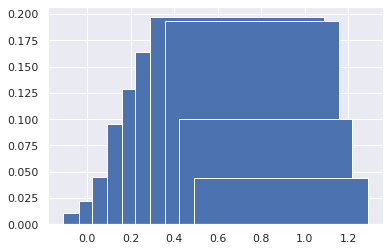

In [273]:
plt.bar(df.val.values, df.freq.values)

(0.0, 1.0)

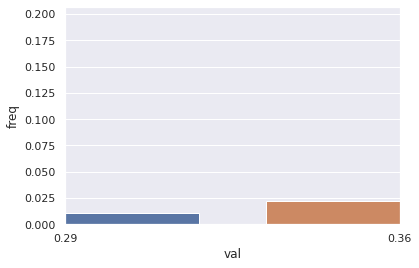

In [276]:
sns.barplot(x=df.val, y=df.freq)
plt.xlim(0,1)

<BarContainer object of 10 artists>

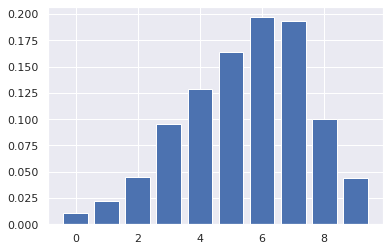

In [258]:
plt.bar(df.bin, df.freq)

TypeError: unsupported operand type(s) for +: 'int' and 'method'

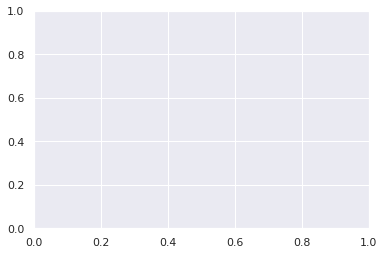

In [259]:
plt.bar(df.bin, df.count)